In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import recall_score, ConfusionMatrixDisplay, classification_report

from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

###Carga de datos

In [2]:
train_df = pd.read_csv('https://raw.githubusercontent.com/LuciaSandalio/AprendizajeSupervisado/refs/heads/master/archive/2023/Pr%C3%A1ctico/diabetes_prediction_dataset_train-labeled.csv')


In [3]:
test_df = pd.read_csv('https://raw.githubusercontent.com/LuciaSandalio/AprendizajeSupervisado/refs/heads/master/archive/2023/Pr%C3%A1ctico/diabetes_prediction_dataset_test.csv')


###Análisis exploratorio de datos

In [4]:
# Información general del dataset
info = train_df.info()
head = train_df.head()
description = train_df.describe()

# Valores nulos
missing_values = train_df.isnull().sum()

# Distribución de la variable target
target_dist = train_df['diabetes'].value_counts(normalize=True)


info, head, description, missing_values, target_dist

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95000 entries, 0 to 94999
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   patient              95000 non-null  int64  
 1   gender               95000 non-null  object 
 2   age                  95000 non-null  float64
 3   hypertension         95000 non-null  int64  
 4   heart_disease        95000 non-null  int64  
 5   smoking_history      95000 non-null  object 
 6   bmi                  95000 non-null  float64
 7   HbA1c_level          95000 non-null  float64
 8   blood_glucose_level  95000 non-null  int64  
 9   diabetes             95000 non-null  int64  
dtypes: float64(3), int64(5), object(2)
memory usage: 7.2+ MB


(None,
    patient  gender   age  hypertension  heart_disease smoking_history    bmi  \
 0    20432    Male   4.0             0              0           never  19.28   
 1    49682  Female  50.0             0              0          former  27.32   
 2    73886  Female  43.0             0              0           never  21.54   
 3    53144    Male  64.0             0              0         current  28.22   
 4    98507    Male  10.0             0              0         No Info  15.46   
 
    HbA1c_level  blood_glucose_level  diabetes  
 0          3.5                  155         0  
 1          5.7                  159         0  
 2          4.5                  145         0  
 3          6.0                  130         0  
 4          6.1                  140         0  ,
              patient           age  hypertension  heart_disease           bmi  \
 count   95000.000000  95000.000000  95000.000000   95000.000000  95000.000000   
 mean    50016.501389     41.935269      0.075

#### Distribución de las variables

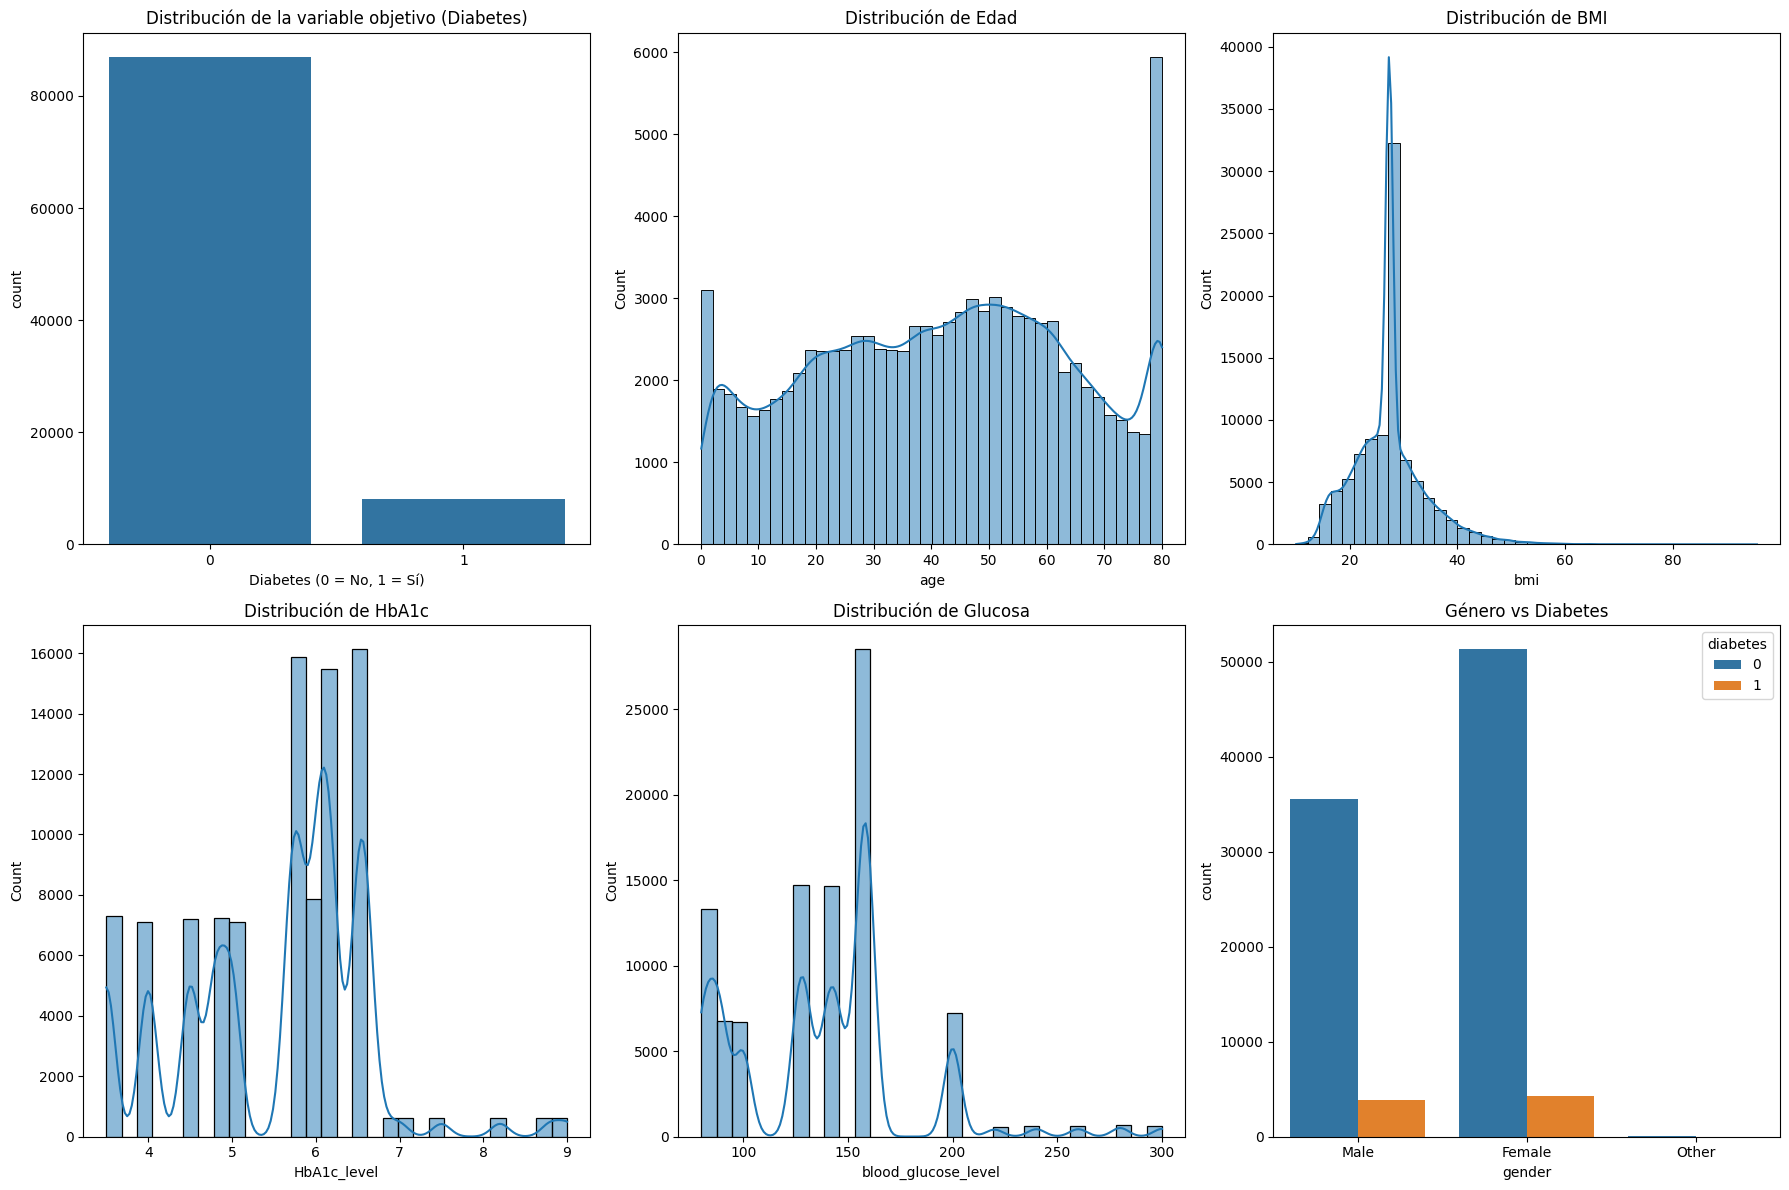

In [5]:
df = train_df
8
fig, axs = plt.subplots(2, 3, figsize=(18, 12))

# 1. Distribución de la variable objetivo
sns.countplot(x='diabetes', data=df, ax=axs[0, 0])
axs[0, 0].set_title("Distribución de la variable objetivo (Diabetes)")
axs[0, 0].set_xlabel("Diabetes (0 = No, 1 = Sí)")

# 2. Distribución de edad
sns.histplot(df['age'], bins=40, kde=True, ax=axs[0, 1])
axs[0, 1].set_title("Distribución de Edad")

# 3. Distribución de BMI
sns.histplot(df['bmi'], bins=40, kde=True, ax=axs[0, 2])
axs[0, 2].set_title("Distribución de BMI")

# 4. Distribución de HbA1c
sns.histplot(df['HbA1c_level'], bins=30, kde=True, ax=axs[1, 0])
axs[1, 0].set_title("Distribución de HbA1c")

# 5. Distribución de glucosa en sangre
sns.histplot(df['blood_glucose_level'], bins=30, kde=True, ax=axs[1, 1])
axs[1, 1].set_title("Distribución de Glucosa")

# 6. Género vs Diabetes
sns.countplot(x='gender', hue='diabetes', data=df, ax=axs[1, 2])
axs[1, 2].set_title("Género vs Diabetes")
plt.tight_layout()
plt.show()


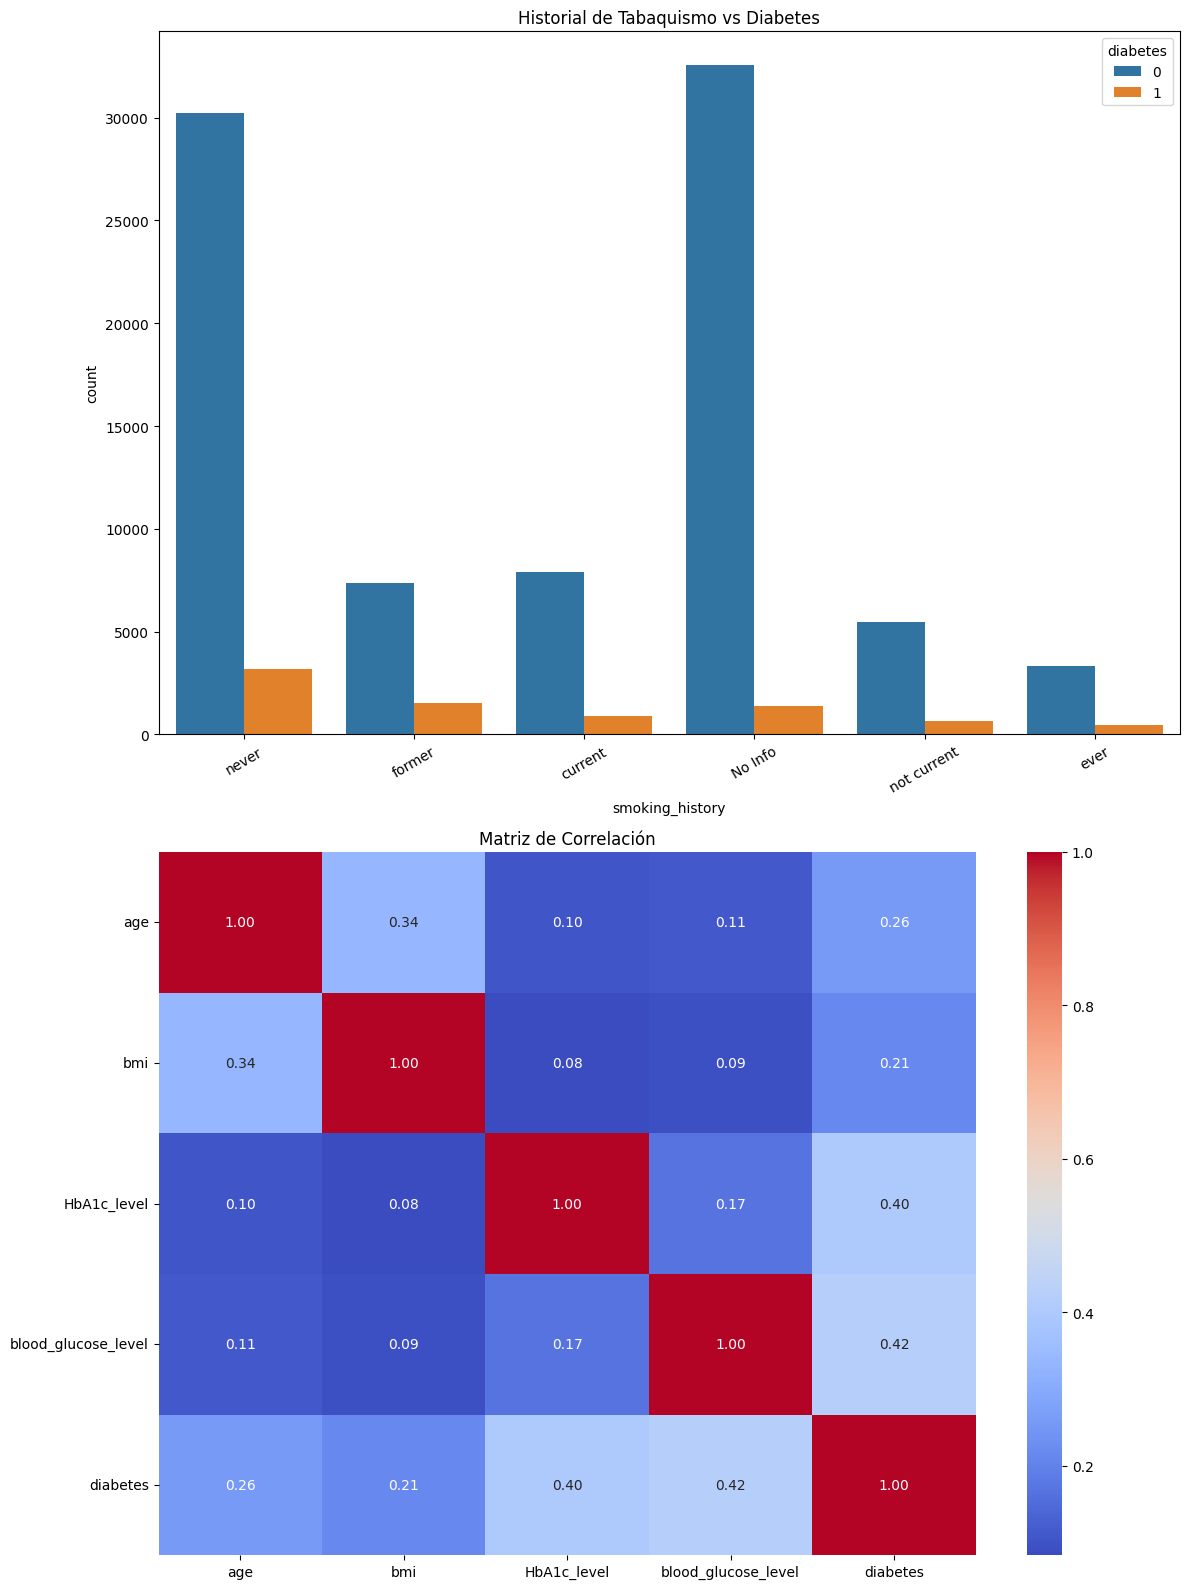

In [6]:
fig, axs = plt.subplots(2, 1, figsize=(12, 16))
# 7. Historial de tabaquismo vs Diabetes
sns.countplot(x='smoking_history', hue='diabetes', data=df, ax=axs[0])
axs[0].set_title("Historial de Tabaquismo vs Diabetes")
axs[0].tick_params(axis='x', rotation=30)

# 8. Matriz de correlación
sns.heatmap(df[['age','bmi','HbA1c_level','blood_glucose_level','diabetes']].corr(),
            annot=True, cmap="coolwarm", fmt=".2f", ax=axs[1])
axs[1].set_title("Matriz de Correlación")

plt.tight_layout()
plt.show()

#### Observaciones:

**Variable objetivo (diabetes):**

Está desbalanceada: la mayoría de los pacientes NO tienen diabetes.

**Distribuciones:**

`Edad:` Distribución amplia, pero más casos en adultos.

`BMI:` Predominio en rangos normales y sobrepeso.

`HbA1c` y `glucosa`: Valores altos se correlacionan con la presencia de diabetes.

**Categorías:**

*Género*: Distribución balanceada entre hombres y mujeres.

*Tabaquismo*: Muchos con "No Info", pero los fumadores actuales y exfumadores parecen tener más casos de diabetes.

**Correlación:**

La mayor correlación con diabetes es: `HbA1c_level` y `blood_glucose_level`.

### Preparamos los datos para el modelado:

In [7]:

X = train_df.drop(['patient', 'diabetes'], axis=1)
y = train_df['diabetes']

# División train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Mostrar tamaños
print("Tamaño train:", X_train.shape)
print("Tamaño test:", X_test.shape)


Tamaño train: (76000, 8)
Tamaño test: (19000, 8)


##Modelado

####Preparemos las variables segun sus tipos y armemos el pipeline para los modelos

In [8]:
# Variables por tipo
num_cols = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']
cat_cols = ['gender', 'smoking_history']
bin_cols = ['hypertension', 'heart_disease']

# Pipelines de preprocesamiento
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipeline, cat_cols)
], remainder='passthrough')

In [9]:
modelos = {
    'Árbol de decisión': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Regresión Logística': LogisticRegression(max_iter=1000, random_state=42)
}
pipelines = {
    nombre: Pipeline([
        ('preprocessing', preprocessor),
        ('classifier', modelo)
    ]) for nombre, modelo in modelos.items()
}


In [10]:
param_grids = {
    'Árbol de decisión': {
        'classifier__criterion': ['gini', 'entropy'],
        'classifier__max_depth': [5, 10, 20],
        'classifier__min_samples_leaf': [1, 2, 5],
        'classifier__min_samples_split': [2, 5, 10],
        'classifier__splitter': ["best", "random"]
    },
    'Random Forest': {
        'classifier__n_estimators': [100, 200],           # 2 valores comunes
        'classifier__max_depth': [None, 10],              # sin límite vs. control moderado
        'classifier__min_samples_split': [2, 10],         # default vs. más conservador
        'classifier__min_samples_leaf': [1, 5],           # default vs. menos sobreajuste
        'classifier__max_features': ['sqrt', 0.5]         # default vs. más aleatoriedad
},
    'Gradient Boosting': {
        'classifier__n_estimators': [100, 200],
        'classifier__learning_rate': [0.01, 0.1, 0.2],
        'classifier__max_depth': [3, 5, 10]
    },
    'Regresión Logística': {
        'classifier__C': [0.01, 0.1, 1, 10],
        'classifier__solver': ['liblinear', 'lbfgs']
    }
}

In [11]:
#Armamos los diccionarios
mejores_modelos = {}
mejores_parametros = {}
mejores_recalls = {}


#Loop para encontrar los mejores hiperparamtros para cada modelo
for nombre, pipeline in pipelines.items():
    print(f"\n Buscando mejores hiperparámetros para {nombre}...")
    grid = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grids[nombre],
        scoring='recall',
        cv=5,
        n_jobs=-1,
        verbose=2
    )
    grid.fit(X_train, y_train)
    print("Mejores hiperparámetros:", grid.best_params_)
    print("Mejor recall (CV):", grid.best_score_)
    mejores_modelos[nombre] = grid.best_estimator_
    mejores_parametros[nombre] = grid.best_params_
    mejores_recalls[nombre] = grid.best_score_


 Buscando mejores hiperparámetros para Árbol de decisión...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END classifier__criterion=gini, classifier__max_depth=5, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__splitter=best; total time=   1.6s
[CV] END classifier__criterion=gini, classifier__max_depth=5, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__splitter=best; total time=   1.2s
[CV] END classifier__criterion=gini, classifier__max_depth=5, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__splitter=best; total time=   0.9s
[CV] END classifier__criterion=gini, classifier__max_depth=5, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__splitter=random; total time=   0.6s
[CV] END classifier__criterion=gini, classifier__max_depth=5, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__splitter=random; total time=   1.2s
[CV] EN

KeyboardInterrupt: 

In [ ]:
res_test = []

for nombre, modelo in mejores_modelos.items():
    y_pred = modelo.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(f" {nombre} - Clasification report en test set:")
    print(classification_report(y_test, y_pred))
    res_test.append({'Modelo': nombre, 'Accuracy': acc, 'Recall': rec, 'Precision': prec, 'F1-score': f1})

In [ ]:
df_test = pd.DataFrame(res_test).set_index('Modelo')
display(df_test)

plt.figure(figsize=(10,6))
df_test[['Accuracy', 'Recall', 'Precision', 'F1-score']].plot.bar(rot=20)
plt.title("Comparación de modelos en Test Set")
plt.ylim(0.0, 1.0)
plt.ylabel("Score")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

In [ ]:
df_test_kaggle = test_df.copy()
patient_ids = df_test_kaggle['patient']
X_test_kaggle = df_test_kaggle.drop('patient', axis=1)


In [ ]:
# Diccionario con los mejores modelos ya entrenados
mejores_modelos = {
    'Árbol de decisión': mejor_modelo_dt,       # ejemplo: modelo entrenado con mejores params
    'Random Forest': mejor_modelo_rf,
    'Gradient Boosting': mejor_modelo_gb,
    'Regresión Logística': mejor_modelo_lr
}

# Diccionario de sufijos para los nombres de archivo
nombres_archivos = {
    'Árbol de decisión': 'dt',
    'Random Forest': 'rf',
    'Gradient Boosting': 'gb',
    'Regresión Logística': 'lr'
}

# Iterar por cada modelo, hacer predicción y guardar CSV
for nombre_modelo, modelo in mejores_modelos.items():
    # Predecir
    y_pred_kaggle = modelo.predict(X_test_kaggle)
    
    # Crear DataFrame de submission
    submission_df = pd.DataFrame({
        'patient': patient_ids,
        'diabetes': y_pred_kaggle
    })
    
    # Guardar CSV
    sufijo = nombres_archivos[nombre_modelo]
    archivo_csv = f'kaggle_submission_{sufijo}.csv'
    submission_df.to_csv(archivo_csv, index=False)
    
    print(f"✔️ Archivo guardado: {archivo_csv}")
